## Установка пакетов: keras-cv и TensorFlow

In [2]:
!pip install keras-cv==0.4.0 -q
!pip install -U tensorflow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.3/595.3 kB 10.3 MB/s eta 0:00:00


## Импорт библиотек и модулей:

In [3]:
from textwrap import wrap
import os
import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from tensorflow import keras

## Загрузка данных и предобработка текста:
Мы используем набор данных с подписями к изображениям домов.

In [4]:
from google.colab import drive

# Монтируем Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Загрузка нашего датафрейма из предыдущих шагов.

In [5]:
# Загружаем данные из CSV-файла
data_frame = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Study/DrawHomeAI/Project/Dataset.csv')

# Переименовываем столбцы 'img' и 'descr' в 'image' и 'caption' соответственно
data_frame = data_frame.rename(columns={'img': 'image', 'descr': 'caption'})

# Выводим первые несколько строк данных
data_frame.head()

,image,caption
0,https://st.hzcdn.com/fimgs/pictures/house-exte...,a large minimalist multicolored three-story st...
1,https://st.hzcdn.com/fimgs/pictures/exteriors/...,a large contemporary multicolored three-story ...
2,https://st.hzcdn.com/fimgs/pictures/exteriors/...,a large elegant red three-story brick exterior...
3,https://st.hzcdn.com/fimgs/pictures/exteriors/...,a large mediterranean white two-story stucco h...
4,https://st.hzcdn.com/fimgs/pictures/exteriors/...,a mid-sized arts and crafts gray two-story woo...


Поскольку у нас есть только 1940 пар {image, caption}, мы можем предварительно вычислить текстовые вложения из подписей. Более того, текстовый кодировщик будет заморожен в процессе тонкой настройки, так что мы можем сэкономить немного мощностикомпьютера, сделав это.

Прежде чем мы воспользуемся текстовым кодировщиком, нам нужно токенизировать подписи.

In [6]:
# Задаем константы для токенизатора текста
PADDING_TOKEN = 49407
MAX_PROMPT_LENGTH = 77

# Создаем экземпляр токенизатора
tokenizer = SimpleTokenizer()

# Метод для токенизации и заполнения токенов
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    return np.array(tokens)

# Собираем токенизированные подписи в массив
tokenized_texts = np.empty((len(data_frame), MAX_PROMPT_LENGTH))

all_captions = list(data_frame["caption"].values)
for i, caption in enumerate(all_captions):
    tokenized_texts[i] = process_text(caption)

1356917/1356917 [==============================] - 0s 0us/step


## Подготовка tf.data.Dataset
Подготовка tf.data.Dataset на основе загруженных по https ссылка изображениям и соответствующих им маркеров подписи.

In [7]:
import requests
import tempfile
import tensorflow as tf
from tensorflow import keras
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder

RESOLUTION = 256
AUTO = tf.data.AUTOTUNE
POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

# Создаем последовательность слоев для аугментации изображений
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.CenterCrop(RESOLUTION, RESOLUTION),
        keras_cv.layers.RandomFlip(),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)

# Создаем экземпляр text_encoder
text_encoder = TextEncoder(MAX_PROMPT_LENGTH)

# Метод для обработки изображений и токенизированного текста
def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
    return image, tokenized_text

# Метод для применения аугментации к пакету изображений и токенов
def apply_augmentation(image_batch, token_batch):
    return augmenter(image_batch), token_batch

# Метод для выполнения text_encoder
def run_text_encoder(image_batch, token_batch):
    return (
        image_batch,
        token_batch,
        text_encoder([token_batch, POS_IDS], training=False),
    )

# Метод для подготовки словаря данных
def prepare_dict(image_batch, token_batch, encoded_text_batch):
    return {
        "images": image_batch,
        "tokens": token_batch,
        "encoded_text": encoded_text_batch,
    }

# Метод для загрузки и сохранения изображений
def download_and_save_image(image_url):
    with tempfile.NamedTemporaryFile(delete=False) as temp_file:
        response = requests.get(image_url)
        temp_file.write(response.content)
        return temp_file.name

# Метод для подготовки датасета
def prepare_dataset(image_paths, tokenized_texts, batch_size=1):
    # Преобразование URL-адресов в локальные пути к файлам
    local_image_paths = []
    for image_path in image_paths:
        # Скачайте изображение по URL-адресу и сохраните его локально
        local_path = download_and_save_image(image_path)
        local_image_paths.append(local_path)

    dataset = tf.data.Dataset.from_tensor_slices((local_image_paths, tokenized_texts))
    dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.map(process_image, num_parallel_calls=AUTO).batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=AUTO)
    dataset = dataset.map(run_text_encoder, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_dict, num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)

492466864/492466864 [==============================] - 6s 0us/step


Базовая модель стабильной диффузии была обучена с использованием изображений с разрешением 512x512. Изображения из нашего набора имеют разрешение 360x360 и по хорошему его нужно увеличить, с помощью resize, но мы намеренно уменьшим, чтоб постараться уложиться в 15 Гб оперативной графической памяти гугл колаб.

In [8]:
# Подготовка датасета.
training_dataset = prepare_dataset(
    np.array(data_frame["image"]), tokenized_texts, batch_size=4
)

# Получение образца пакета и его исследование.
sample_batch = next(iter(training_dataset))

In [9]:
for k, v in sample_batch.items():
    print(k, v.shape)

images (4, 256, 256, 3)
tokens (4, 77)
encoded_text (4, 77, 768)


Посмотрим на обучающие изображения и соответствующие подписи к ним.

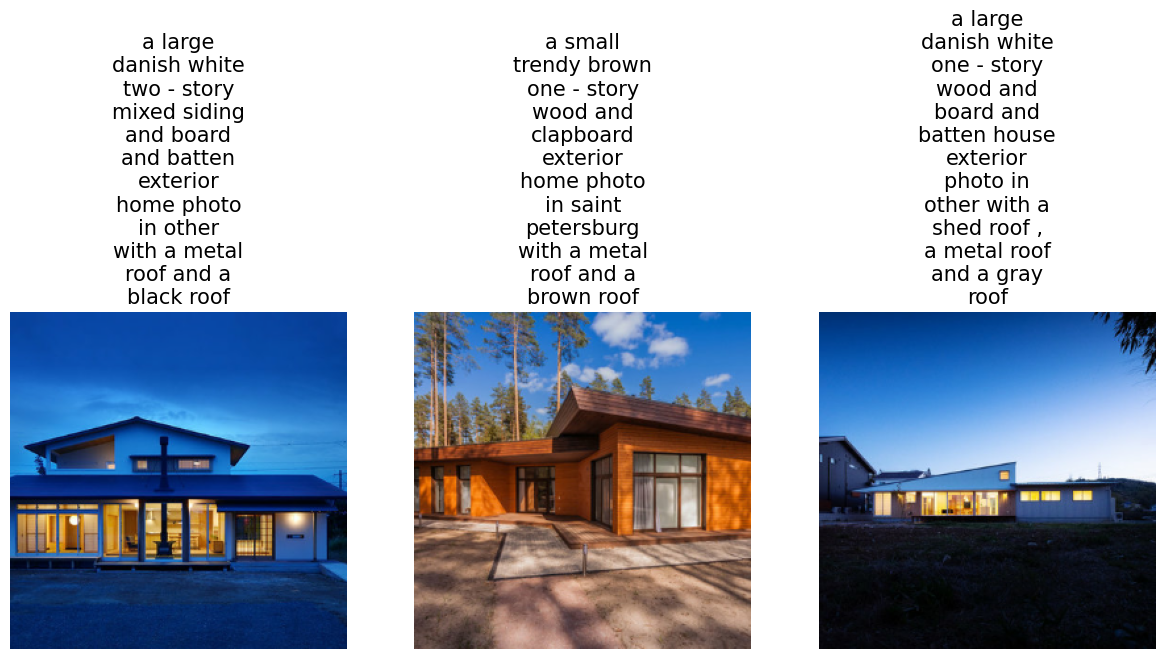

In [10]:
plt.figure(figsize=(20, 10))

for i in range(3):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow((sample_batch["images"][i] + 1) / 2)

    text = tokenizer.decode(sample_batch["tokens"][i].numpy().squeeze())
    text = text.replace("<|startoftext|>", "")
    text = text.replace("<|endoftext|>", "")
    text = "\n".join(wrap(text, 12))
    plt.title(text, fontsize=15)

    plt.axis("off")

## Обучающий класс для цикла fine-tuning

In [11]:
class Trainer(tf.keras.Model):
    # Ссылка:
    # https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py

    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        use_mixed_precision=False,
        max_grad_norm=1.0,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):
        images = inputs["images"]
        encoded_text = inputs["encoded_text"]
        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as tape:
            # Проецируем изображение в латентное пространство и выбираем случайный сэмпл.
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            # Более подробно о магическом числе здесь:
            # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
            latents = latents * 0.18215

            # Генерируем случайный шум, который будем добавлять к латентам.
            noise = tf.random.normal(tf.shape(latents))

            # Выбираем случайный таймстеп для каждого изображения.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Добавляем шум к латентам в соответствии с магнитудой шума на каждом таймстепе
            # (это процесс прямого диффузии).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Получаем цель для функции потерь в зависимости от типа предсказания,
            # в данном случае это просто сэмплированный шум.
            target = noise  # noise_schedule.predict_epsilon == True

            # Предсказываем остаточный шум и вычисляем функцию потерь.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            timestep_embedding = tf.squeeze(timestep_embedding, 1)
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, encoded_text], training=True
            )
            loss = self.compiled_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Обновляем параметры модели диффузии.
        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep


Вместо того, чтобы напрямую брать скрытый вектор, созданный кодировщиком изображений (который является VAE), мы выбираем из предсказанного им среднего значения и логарифмической дисперсии. Таким образом, мы можем добиться лучшей выборки, качество и разнообразие.

## Инициализация компиляция тренажера

In [12]:
class Trainer(tf.keras.Model):

    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        use_mixed_precision=False,
        max_grad_norm=1.0,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):
        images = inputs["images"]
        encoded_text = inputs["encoded_text"]
        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as tape:
            # Проецируем изображение в латентное пространство и выбираем случайный сэмпл.
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            latents = latents * 0.18215

            # Генерируем случайный шум, который будем добавлять к латентам.
            noise = tf.random.normal(tf.shape(latents))

            # Выбираем случайный таймстеп для каждого изображения.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Добавляем шум к латентам в соответствии с магнитудой шума на каждом таймстепе
            # (это процесс прямого диффузии).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Получаем цель для функции потерь в зависимости от типа предсказания,
            # в данном случае это просто сэмплированный шум.
            target = noise

            # Предсказываем остаточный шум и вычисляем функцию потерь.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            timestep_embedding = tf.squeeze(timestep_embedding, 1)
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, encoded_text], training=True
            )
            loss = self.compiled_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Обновляем параметры модели диффузии.
        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        # Переопределение этого метода позволяет использовать коллбэк `ModelCheckpoint`
        # напрямую с этим классом тренера. В данном случае будет сохраняться только
        # модель диффузии, так как мы ее тренируем при выполнении дообучения.
        self.diffusion_model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

3439090152/3439090152 [==============================] - 36s 0us/step


## Fine-tuning

Оптимально конечно делать 70 эпох, но мы будем надеяться, что гугл колаб потянет хотя бы одну.

In [13]:
epochs = 1
ckpt_path = "finetuned_stable_diffusion.h5"
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only=True,
    monitor="loss",
    mode="min",
)
diffusion_ft_trainer.fit(training_dataset, epochs=epochs, callbacks=[ckpt_callback])

Instructions for updating:
Use fn_output_signature instead


ResourceExhaustedError: ignored

Данные ошибки связаны с нехваткой графической памяти. Даже со всеми урезками у нас не получилось обучить SD. Для обучения на изображениях с разрешением 512x512 (как это хорошо было бы для SD) и с 70 эпохами нам необходим сервер с GPU минимум с 30 Гб.